In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import itertools
import datetime
# postgresql backend
import psycopg2


In [3]:
def vector_cross_product_2d(v1, v2):
    """Compute the 2D scalar cross product of two vectors."""
    return v1[0] * v2[1] - v1[1] * v2[0]

def check_intersection(line1, line2):
    """Check if two lines on a circle intersect."""
    p1, p2 = line1
    p3, p4 = line2
    
    # Check if points from line2 lie on opposite sides of line1
    cross1 = vector_cross_product_2d(p2 - p1, p3 - p1)
    cross2 = vector_cross_product_2d(p2 - p1, p4 - p1)
    
    # Check if points from line1 lie on opposite sides of line2
    cross3 = vector_cross_product_2d(p4 - p3, p1 - p3)
    cross4 = vector_cross_product_2d(p4 - p3, p2 - p3)
    
    # If the signs of the cross products are different, the lines intersect
    return (cross1 * cross2 < 0) and (cross3 * cross4 < 0)

In [4]:
class GhostBuster:
    def __init__(self, ghostbuster_type, position="", ID=""):
        self.ghostbuster_type = ghostbuster_type  # Can be 'alien' or 'camper'
        self.position = position  # Initialized as empty
        self.ID = ID  # Initialized as empty

gb = GhostBuster("camper")
gb.__dict__

{'ghostbuster_type': 'camper', 'position': '', 'ID': ''}

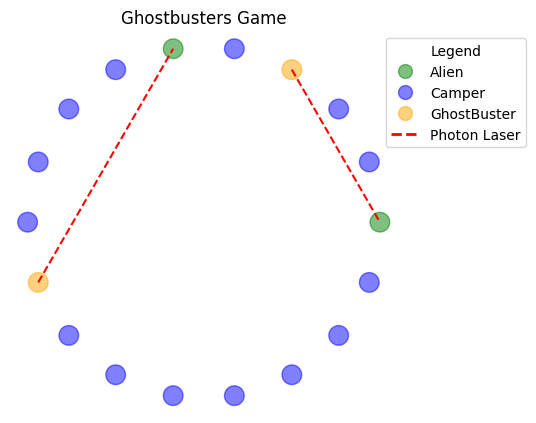

THE WORLD IS SAVED
1 item inserted successfully
{'game_create_time': datetime.datetime(2024, 10, 15, 17, 51, 45, 916537), 'game_num_campers': 18, 'game_num_pairs': 2, 'game_result': 1}


In [1]:
import random
import string
import matplotlib.pyplot as plt
import numpy as np

# GhostBuster class definition
class GhostBuster:
    def __init__(self, ghostbuster_type, position="", ID=""):
        self.ghostbuster_type = ghostbuster_type  # Can be 'camper' or 'alien'
        self.position = position  # Initialized as empty
        self.ID = ID  # Initialized as empty

# gb_game_state class definition (Base class)
class gb_game_state:
    def __init__(self, num_campers, num_pairs, game_type):
        # Check if num_campers is greater than 26
        if num_campers > 26:
            raise ValueError("num_campers must be 26 or less.")
        
        # Check if num_pairs is greater than half of num_campers
        if num_pairs > num_campers // 2:
            raise ValueError("num_pairs must be less than or equal to half of num_campers.")
        
        # Check if num_campers is even
        if num_campers % 2 != 0:
            raise ValueError("num_campers must be an even integer.")
        
        self.num_campers = num_campers  # Even integer
        self.num_pairs = num_pairs
        self.type = game_type  # Either "random" or "manual"
        self.game_ID = self.generate_game_id()  # Random string generated on init
        self.ghostbusters = []  # list containing all ghostbusters instances
        self.campers = []  # list containing all ghostbusters instances with type "camper"
        self.aliens = []  # list containing all ghostbusters instances with type "alien"
        self.game_letters = string.ascii_uppercase[:self.num_campers]
        self.target_dict = {}

    def generate_game_id(self):
        # Generate a random string of 8 characters for the game ID
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))
    
    def create_ghostbusters(self):
        letter_index = 0
        
        # Create one camper and one alien ghostbuster for each pair
        for _ in range(self.num_pairs):
            # Create one camper ghostbuster and assign an ID using letters
            camper_id = self.game_letters[letter_index]
            camper_ghostbuster = GhostBuster('camper', ID=camper_id)
            self.ghostbusters.append(camper_ghostbuster)
            self.campers.append(camper_ghostbuster)
            letter_index += 1

        for _ in range(self.num_pairs):    
            # Create one alien ghostbuster and assign an ID using letters
            alien_id = self.game_letters[letter_index]
            alien_ghostbuster = GhostBuster('alien', ID=alien_id)
            self.ghostbusters.append(alien_ghostbuster)
            self.aliens.append(alien_ghostbuster)
            letter_index += 1
    
    def set_ghostbuster_positions_rand(self):
        # Generate a list of unique random positions
        unique_positions = random.sample(range(self.num_campers), self.num_campers)
        
        # Assign positions to ghostbusters
        for i, ghostbuster in enumerate(self.ghostbusters):
            ghostbuster.position = unique_positions[i]

    def set_targets(self):

        for i in np.arange(0,self.num_pairs):
            self.target_dict[self.campers[i].ID] = self.aliens[i].ID
        
        return self.target_dict

# New gb_game_rep class using composition (holds an instance of gb_game_state)
class gb_game_rep:
    def __init__(self, game_state,verbose = False):
        # Store the game_state instance in the gb_game_rep class
        self.game_state = game_state

        # store verbosity
        self.verbose = verbose
        
        # Additional attribute for the representation of the game
        self.game_representation = {}

        # initialize list to contain line info
        self.line_list = []

        # initialize game result as success
        self.game_result = 'SUCCESS'

    def create_game_rep(self, aliens=[19, 5,6]):
        # Create a DataFrame to hold positions
        df = pd.DataFrame(np.arange(0, self.game_state.num_campers), columns=['POSITION'])
        df['ANGLES'] = np.linspace(0, 2 * np.pi, df.shape[0], endpoint=False)
        df['XPOS'] = 5 * np.cos(df['ANGLES'])
        df['YPOS'] = 5 * np.sin(df['ANGLES'])

        # bring in camper locations from game state
        campers = [c.position for c in self.game_state.campers]
        aliens = [a.position for a in self.game_state.aliens]

        # Initialize camper indicator
        df['CAMPER_IND'] = 0  # Use 0 as the default indicator
        df.loc[campers, 'CAMPER_IND'] = 1  # Set 1 for campers

        # Initialize alien indicator
        df['ALIEN_IND'] = 0  # Use 0 as the default indicator
        df.loc[aliens, 'ALIEN_IND'] = 1  # Set 1 for aliens

        # Assign colors based on indicators
        df['COLOR'] = 'blue'  # Default color
        df.loc[df['ALIEN_IND'] == 1, 'COLOR'] = 'green'  # Set color for aliens
        df.loc[df['CAMPER_IND'] == 1, 'COLOR'] = 'orange'  # Set color for campers

        # Create color list for plotting
        colors = df['COLOR'].tolist()

        # Create the scatter plot
        if self.verbose:
            # Create figure and axis
            fig, ax = plt.subplots(figsize=(5, 5))  # Create figure and axis

            # Plot the scatter plot
            scatter = ax.scatter(df['XPOS'], df['YPOS'], c=colors, s=200, edgecolors=colors, alpha=0.5)

            # Set equal aspect ratio
            ax.set_aspect('equal', adjustable='box')

            # Remove the axes and labels
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks

            # Hide the spines (the borders around the plot)
            ax.spines['top'].set_visible(False)     # Hide top spine
            ax.spines['right'].set_visible(False)   # Hide right spine
            ax.spines['left'].set_visible(False)    # Hide left spine
            ax.spines['bottom'].set_visible(False)  # Hide bottom spine

            # Set the title for the axis
            ax.set_title('Ghostbusters Game')

            # Create a legend based on the colors
            # Assume df['COLORS'] holds categories like 'Campers', 'Aliens', etc., and is mapped to `colors`
            unique_colors = df['COLOR'].unique()  # Get unique categories in df['COLORS']
            legend_handles = []

            legend_dict = {'blue':'Camper','green':'Alien','orange':'GhostBuster'}

            # Create a custom handle for each unique category
            for color in unique_colors:
                # Create a handle with the same color and label
                handle = mlines.Line2D([], [], color=color, 
                                       marker='o', 
                                       linestyle='None', 
                                       markersize=10, 
                                       alpha = 0.5, 
                                       label=legend_dict[color])
                legend_handles.append(handle)

            ax.legend(handles=legend_handles, title='Legend',loc = 'upper right', bbox_to_anchor=(1.3, 1))

            
        
        for p in np.arange(self.game_state.num_pairs):
            p1 = df.loc[campers[p]]
            p2 = df.loc[aliens[p]]

            self.line_list.append((np.array([p1['XPOS'],p1['YPOS']]),np.array([p2['XPOS'],p2['YPOS']])))
            if self.verbose:
                plt.plot([p1['XPOS'], p2['XPOS']], [p1['YPOS'], p2['YPOS']], color='red', linestyle='--')
                

        
        if self.verbose:
            new_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Photon Laser')

            legend_handles.append(new_line)

            # Update the legend with the new handle
            ax.legend(handles=legend_handles, title='Legend', loc='upper right', bbox_to_anchor=(1.35, 1))
            plt.show()
        
        
    
    def check_result(self):
        print(check_intersection(self.line_list[0], self.line_list[1]))
        pass

    def evaluate_game(self):
        int_tests = []
        for pair in itertools.combinations(self.line_list, 2):
            int_tests.append(check_intersection(pair[0], pair[1]))
        if any(element is np.True_ for element in int_tests):
            self.game_result = 0
            if self.verbose:
                print('AT LEAST 2 PROTON BEAMS COLLIDED')
        else:
            self.game_result = 1
            if self.verbose:
                print("THE WORLD IS SAVED")

        self.game_dict = {"game_create_time":datetime.datetime.now(),
             "game_num_campers":self.game_state.num_campers,
             "game_num_pairs":self.game_state.num_pairs,
             "game_result":self.game_result}
        
    def write_game_result(self):
        try:
            connection = psycopg2.connect(user="postgres",
                                        password="postgres",
                                        host="127.0.0.1",
                                        port="5432",
                                        database="postgres")

            cursor = connection.cursor()
            # Executing a SQL query to insert datetime into table
            insert_query = """ INSERT INTO riddler.ghostbusters ("game_create_time",
                    "game_num_campers",
                    "game_num_pairs",
                    "game_result") VALUES (%s, %s, %s, %s)"""
            sql_record = (self.game_dict["game_create_time"],
                self.game_dict["game_num_campers"],
                self.game_dict["game_num_pairs"],
                self.game_dict["game_result"])
            cursor.execute(insert_query, sql_record)
            connection.commit()
            print("1 item inserted successfully")

        except (Exception, psycopg2.Error) as error:
            print("Error while connecting to PostgreSQL", error)
        finally:
            if connection:
                cursor.close()
                connection.close()

        

# Example usage
try:
    # Initialize gb_game_state
    game_state = gb_game_state(18, 2, "random")
    game_state.create_ghostbusters()
    game_state.set_ghostbuster_positions_rand()

    # Initialize gb_game_rep with game_state
    game_rep = gb_game_rep(game_state,verbose=True)

    # Create and display game representation
    game_rep.create_game_rep()
    game_rep.evaluate_game()
    game_rep.write_game_result()
    print(game_rep.game_dict)


    
except ValueError as e:
    print(e)


In [6]:
class game_simulator:
    def __init__(self, num_campers, num_pairs, num_trials):
        """Initialize the simulator with the number of campers, pairs, and trials."""
        self.num_campers = num_campers
        self.num_pairs = num_pairs
        self.num_trials = num_trials
        self.trial_results = []  # List to store the result of each trial
    
    def run_simulation(self):
        """Run the game simulation for the specified number of trials."""
        for trial in range(self.num_trials):
            # print(f"Running trial {trial + 1}...")
            
            # Initialize gb_game_state
            try:
                game_state = gb_game_state(self.num_campers, self.num_pairs, "random")
                game_state.create_ghostbusters()
                game_state.set_ghostbuster_positions_rand()

                # Initialize gb_game_rep with game_state
                game_rep = gb_game_rep(game_state)

                # Create and evaluate the game representation
                game_rep.create_game_rep()
                game_rep.evaluate_game()

                # Record the result of this trial
                self.trial_results.append(game_rep.game_result)

            except ValueError as e:
                print(f"Error in trial {trial + 1}: {e}")
                self.trial_results.append("ERROR")

    def report_results(self):
        """Print a summary of the simulation results, including failure percentage."""
        success_count = self.trial_results.count('SUCCESS')
        fail_count = self.trial_results.count('FAIL')
        error_count = self.trial_results.count('ERROR')

        total_valid_trials = success_count + fail_count  # Exclude errors
        failure_percentage = (fail_count / total_valid_trials) * 100 if total_valid_trials > 0 else 0

        print("\nSimulation Results Summary:")
        print(f"Total Trials: {self.num_trials}")
        print(f"Successful Trials: {success_count}")
        print(f"Failed Trials: {fail_count}")
        print(f"Errors: {error_count}")
        print(f"Failure Percentage: {failure_percentage:.2f}%")


In [11]:
# Create a game simulator with 26 campers, 2 pairs, and 10 trials
simulator = game_simulator(num_campers=20, num_pairs=8, num_trials=10000)

# Run the simulation
simulator.run_simulation()

# Report the results
simulator.report_results()



Simulation Results Summary:
Total Trials: 10000
Successful Trials: 6
Failed Trials: 9994
Errors: 0
Failure Percentage: 99.94%


In [17]:
game_dict = {"game_create_time":datetime.datetime.now(),
             "game_num_campers":20,
             "game_num_pairs":2,
             "game_result":1}

sql_record = (game_dict["game_create_time"],
              game_dict["game_num_campers"],
              game_dict["game_num_pairs"],
              game_dict["game_result"])

sql_record

(datetime.datetime(2024, 10, 15, 14, 41, 10, 721988), 20, 2, 1)

In [19]:
def write_game_result():
    try:
        connection = psycopg2.connect(user="postgres",
                                    password="postgres",
                                    host="127.0.0.1",
                                    port="5432",
                                    database="postgres")

        cursor = connection.cursor()
        # Executing a SQL query to insert datetime into table
        insert_query = """ INSERT INTO riddler.ghostbusters ("game_create_time",
                "game_num_campers",
                "game_num_pairs",
                "game_result") VALUES (%s, %s, %s, %s)"""
        cursor.execute(insert_query, sql_record)
        connection.commit()
        print("1 item inserted successfully")

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL", error)
    finally:
        if connection:
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

1 item inserted successfully
PostgreSQL connection is closed


In [ ]:
# analytics
# show probability for 20,2
# show probability for all pairs
# show total games played (last 7 days)
# show 

In [56]:
# Function to fetch query results and return a DataFrame
def fetch_query_as_dataframe(query, connection_params):
    try:
        # Connect to your PostgreSQL database
        conn = psycopg2.connect(**connection_params)
        
        # Create a cursor object
        cursor = conn.cursor()
        
        # Execute the query
        cursor.execute(query)
        
        # Fetch all rows from the executed query
        rows = cursor.fetchall()
        
        # Get column names from the cursor
        colnames = [desc[0] for desc in cursor.description]
        
        # Close the cursor and connection
        cursor.close()
        conn.close()
        
        # Return the results as a pandas DataFrame
        return pd.DataFrame(rows, columns=colnames)
    
    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage
connection_params = {
    'user':"postgres",
    'password':"postgres",
    'host':"127.0.0.1",
    'port':"5432",
    'database':"postgres"
}

query = """SELECT  game_num_pairs,
round(100*sum(CASE WHEN game_result = 0 then 0
ELSE 1
END)/count(*)::numeric,2) AS SUCCESS_RATE_PCT,
count(*) AS COUNT
FROM riddler.ghostbusters
-- WHERE game_num_campers = 20
-- AND game_num_pairs = 2
GROUP BY game_num_pairs
ORDER BY  game_num_pairs;"""

df = fetch_query_as_dataframe(query, connection_params)

print(df)

   game_num_pairs success_rate_pct  count
0               2            67.48   1467
1               3            23.08     39
2               4            10.24    127
3               5             2.82     71


In [37]:
fail_count = df.loc[df['game_result'] == 0]['count']
success_count = df.loc[df['game_result'] == 1]['count']
fail_rate = int(fail_count.iloc[0])/df['count'].sum()
f"{fail_rate:.2%}"

'33.63%'